In [16]:
from src import *
from src.AFSC import *
import matplotlib.pyplot as plt 
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, fowlkes_mallows_score,silhouette_score,davies_bouldin_score
import pickle

In [17]:
parser = argparse.ArgumentParser()
parser.add_argument("--checkpoint", default=1, help="1 represents using the trained model.")
parser.add_argument("--need_k", default=0, help="1 represents using the k neighbors.")
parser.add_argument("--k", default=50, help="The number of neighbors. Default is 50")
parser.add_argument("--pca_dim", default=1000, help="The dim of pca. Default is 1000")

parser.add_argument("--layers", nargs='?', default='[256]', help="The number of units of each layer of the GNN. Default is [256]")
parser.add_argument("--pred_hid", type=int, default=512, help="The number of hidden units of layer of the predictor. Default is 512")

parser.add_argument("--topk", type=int, default=50, help="The number of neighbors to search")
parser.add_argument("--clus_num_iters", type=int, default=20)
parser.add_argument("--num_centroids", type=int, default=80, help="The number of centroids for K-means Clustering")
parser.add_argument("--num_kmeans", type=int, default=5, help="The number of K-means Clustering for being robust to randomness")

parser.add_argument("--eval_freq", type=float, default=5, help="The frequency of model evaluation")
parser.add_argument("--mad", type=float, default=0.9, help="Moving Average Decay for Teacher Network")
parser.add_argument("--lr", type=float, default=0.001, help="learning rate")    
parser.add_argument("--es", type=int, default=3000, help="Early Stopping Criterion")
parser.add_argument("--device", type=int, default=0)
parser.add_argument("--epochs", type=int, default=500)
parser.add_argument("--dropout", type=float, default=0.0)
args, _=parser.parse_known_args()

In [18]:
adata = read_adata('/home/hanr/AFSC/datasets/spot/10X_Human_Breast_Cancer','filtered_feature_bc_matrix.h5')

/home/hanr/anaconda3/envs/CCST2/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


In [19]:
adata = read_label(adata,'/home/hanr/AFSC/datasets/spot/10X_Human_Breast_Cancer/metadata.tsv',"ground_truth")

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial', 'label'


In [20]:
adata = process_adata(adata,args.pca_dim,args.k)

AnnData object with n_obs × n_vars = 3798 × 22240
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial', 'log1p'
    obsm: 'spatial', 'label', 'X_pca', 'distance', 'adj_k', 'distance_k'


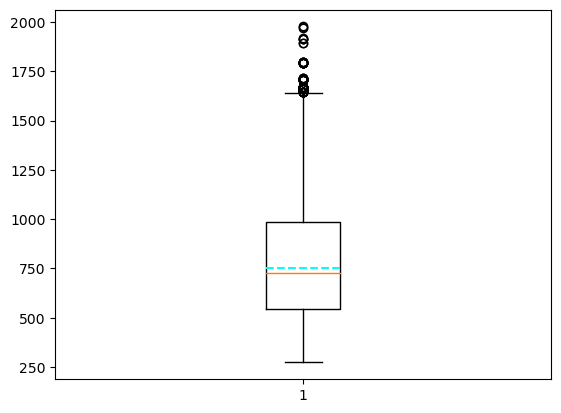

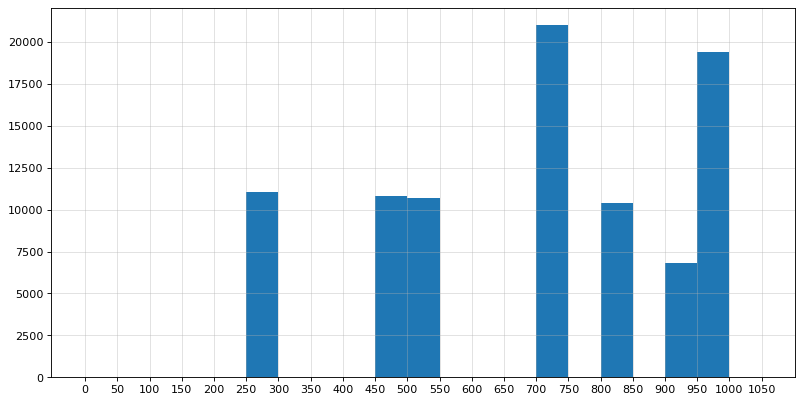

In [21]:
DIS_K=adata.obsm['distance_k']
DIS_K_plot=DIS_K[np.triu_indices(DIS_K.shape[0],k=1)]
DIS_K_plot=DIS_K_plot[DIS_K_plot>0] 
#箱线图
plt.boxplot(DIS_K_plot, showmeans=True, meanline=True,meanprops={'color': 'cyan', 'linewidth': 1.5})
plt.show()
num_bin=[0]
#直方图
i=0
while i<=1000:
    i+=50
    num_bin.append(i)
plt.figure(dpi=80,figsize=(12,6))
plt.hist(DIS_K_plot, num_bin)
plt.xticks(num_bin)
plt.grid(alpha=0.4)
plt.show()

In [22]:
def train(adata,threshold_list):
    best_ari = 0
    for threshold in threshold_list:
        print("**************************************************************")
        print(threshold)
        data = prepare_data(adata,args.need_k,threshold)
        model_AFSL =cluster()
        #Run
        model_AFSL.train(data,args,n_clusters=20,init_spa=True,res=0.7, tol=5e-3, lr=0.05, max_epochs=500)
        y_pred, x =model_AFSL.predict()
        refined_pred=refine(adata,sample_id=adata.obs.index.tolist(), pred=y_pred.tolist())
        adata.obs["pred"]=refined_pred
        NMI = normalized_mutual_info_score(adata.obsm["label"], adata.obs["pred"], average_method='arithmetic')
        ARI = adjusted_rand_score(adata.obsm["label"], adata.obs["pred"])
        FMI = fowlkes_mallows_score(adata.obsm["label"], adata.obs["pred"]) 
        SC = silhouette_score(x.detach().numpy(), adata.obs["pred"])
        DBI = davies_bouldin_score(x.detach().numpy(), adata.obs["pred"])
        print('===== ARI:{:.2f},NMI:{:.2f},FMI:{:.2f},SC:{:.2f},DBI:{:.2f} ===='.format(ARI,NMI,FMI,SC,DBI))
        if ARI > best_ari:
            best_ari = ARI
            label = np.ascontiguousarray(refined_pred) 
            df_label = pd.DataFrame(label,columns=['label'])
            df_label.to_csv('./results/label/BRCA.csv',index=False)
            np.save(f'./results/feat/BRCA.npy', x.detach().numpy())
            output_hal = open("./results/model/BRCA.pkl", 'wb')
            s = pickle.dumps(model_AFSL)
            output_hal.write(s)
            output_hal.close()
            print('save')
        torch.cuda.empty_cache()

In [25]:
def test(adata,checkpoint_path):
    model_AFSL = cluster()
    with open(checkpoint_path,'rb') as file:
        model_AFSL  = pickle.loads(file.read())

    y_pred, x =model_AFSL.predict()
    refined_pred=refine(adata,sample_id=adata.obs.index.tolist(), pred=y_pred.tolist())
    adata.obs["pred"]=refined_pred
    NMI = normalized_mutual_info_score(adata.obsm["label"], adata.obs["pred"], average_method='arithmetic')
    ARI = adjusted_rand_score(adata.obsm["label"], adata.obs["pred"])
    FMI = fowlkes_mallows_score(adata.obsm["label"], adata.obs["pred"]) 
    SC = silhouette_score(x.detach().numpy(), adata.obs["pred"])
    DBI = davies_bouldin_score(x.detach().numpy(), adata.obs["pred"])
    print('===== ARI:{:.2f},NMI:{:.2f},FMI:{:.2f},SC:{:.2f},DBI:{:.2f} ===='.format(ARI,NMI,FMI,SC,DBI))

In [26]:
if args.checkpoint == 0:
    threshold_list=[500,850,1000]
    train(adata,threshold_list)
else:
    test(adata,'/home/hanr/AFSC/results/model/BRCA.pkl')

/home/hanr/AFSC/src/AFSC.py:159: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352430114/work/torch/csrc/utils/tensor_new.cpp:204.)
  indices = torch.tensor([index, similar]).to(self.device)


===== ARI:0.631,NMI:0.692,FMI:0.662,SC:0.594,DBI:0.710 ====
